In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython

sample_rate = 44100

def p(a):
    return IPython.display.Audio( a, rate=sample_rate, autoplay = False )

In [5]:
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 8)



Populating the interactive namespace from numpy and matplotlib


In [45]:
def sinBuf( freq ):
    n = (int)( sample_rate / 10.0 )
    t = np.linspace( 0, n-1, n ) / sample_rate
    return np.sin( t * 2 * np.pi * freq)
    
def bufMag( buf ):
    rms = np.sqrt(np.mean(np.multiply( buf, buf ))) / sqrt( 2 )
    return rms

In [46]:
class APF:
    def __init__(self, zR, zI ):
        self.om1 = 0
        self.om2 = 0
        self.im1 = 0
        self.im2 = 0
        self.zR = zR
        self.zI = zI
        self.mz2 = zR * zR + zI * zI
        
    def setPolar( self, r, th ):
        self.mz2 = r * r
        self.zR = r * cos( th )
        
    def process( self, inp ):
        out = 0;
        
        out = ( self.mz2 * ( inp - self.om2 ) 
               - 2 * self.zR * ( self.im1 - self.om1 ) 
               + self.im2 )
        
        self.om2 = self.om1
        self.om1 = out
        
        self.im2 = self.im1
        self.im1 = inp
        
        return out
    

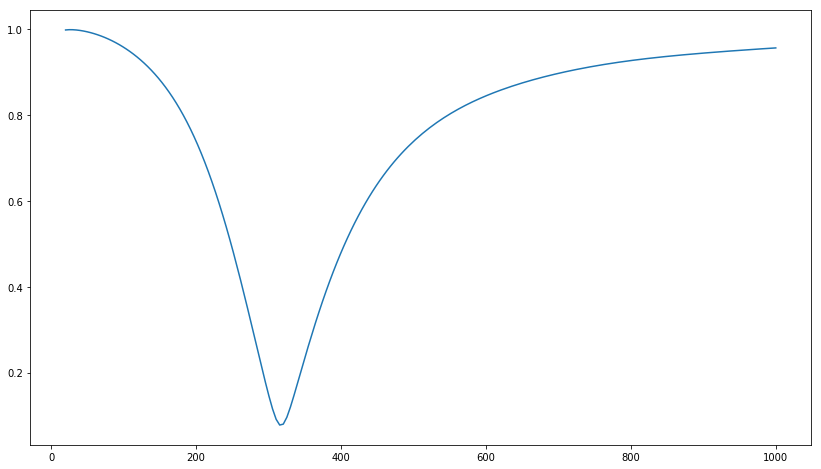

In [47]:
# OK so lets do a scan
def rmsAtF( freq ):
    a = APF( 0.98, 0.04 )
    s = sinBuf( freq )
    r = [ a.process( x ) for x in s ]
    return  bufMag( s + r )

freqT = np.linspace( 20, 1000, 200 )
res = [ rmsAtF( f ) for f in freqT ]
plt.plot( freqT, res )

In [48]:
# Lets check a few examples
def pv( f ):
    print( "CHECK( rmsAtF( 0.98, 0.04, ", f, ") == Approx( %8.6ff" % round( rmsAtF( f ), 6 ), ").margin( 5e-5 ) );")
    
    
pv( 100 )
pv( 200 )
pv( 300 )
pv( 400 )
pv( 500 )

CHECK( rmsAtF( 0.98, 0.04,  100 ) == Approx( 0.957165f ).margin( 5e-5 ) );
CHECK( rmsAtF( 0.98, 0.04,  200 ) == Approx( 0.742463f ).margin( 5e-5 ) );
CHECK( rmsAtF( 0.98, 0.04,  300 ) == Approx( 0.148971f ).margin( 5e-5 ) );
CHECK( rmsAtF( 0.98, 0.04,  400 ) == Approx( 0.479301f ).margin( 5e-5 ) );
CHECK( rmsAtF( 0.98, 0.04,  500 ) == Approx( 0.737406f ).margin( 5e-5 ) );


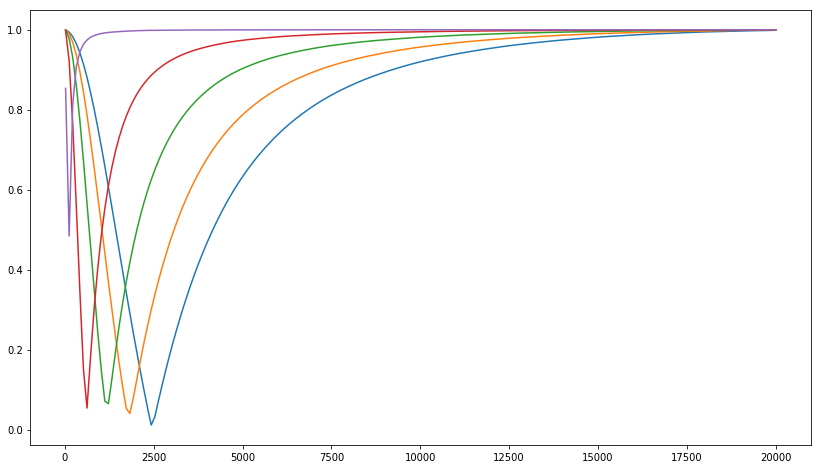

In [49]:
def rmsAtFWithA( a, freq ):
    s = sinBuf( freq )
    r = [ a.process( x ) for x in s ]
    return bufMag( s + r )


def scanForP( zr, zi ):
    a = APF( zr, zi )
    freqT = np.linspace( 20, 20000, 200 )
    res = [ rmsAtFWithA( a, f ) for f in freqT ]
    return [ freqT, res ];

for r in np.linspace( 0.7, 0.99, 5 ):
    d = scanForP( r, 0.0 )
    plt.plot( d[ 0 ], d[ 1 ] )



In [71]:
# So lets try that in  a different way
def rmsAt( zr, zi, f ):
    a = APF( zr, zi );
    return rmsAtFWithA( a, f )

def pav( zr, zi, f ):
    print( "  CHECK( rmsAtF( %lf, %lf, %lf ) = " % ( zr, zi, f ), 
        "Approx( %8.6lff ).margin( 5e-5 ) )" % round( rmsAt( zr, zi, f ), 6 )
         )


pav( 0.85, 0.1, 940 )
pav( 0.1, 0.85, 10643 )
pav( 0.95 * cos( 0.2 ), 0.95 * sin( 0.2 ), 1700 )


  CHECK( rmsAtF( 0.850000, 0.100000, 940.000000 ) =  Approx( 0.430219f ).margin( 5e-5 ) )
  CHECK( rmsAtF( 0.100000, 0.850000, 10643.000000 ) =  Approx( 0.368515f ).margin( 5e-5 ) )
  CHECK( rmsAtF( 0.931063, 0.188736, 1700.000000 ) =  Approx( 0.543379f ).margin( 5e-5 ) )


theta=0.000000
theta=0.314159
theta=0.628319
theta=0.942478
theta=1.256637
theta=1.570796
theta=1.884956
theta=2.199115
theta=2.513274
theta=2.827433
theta=3.141593


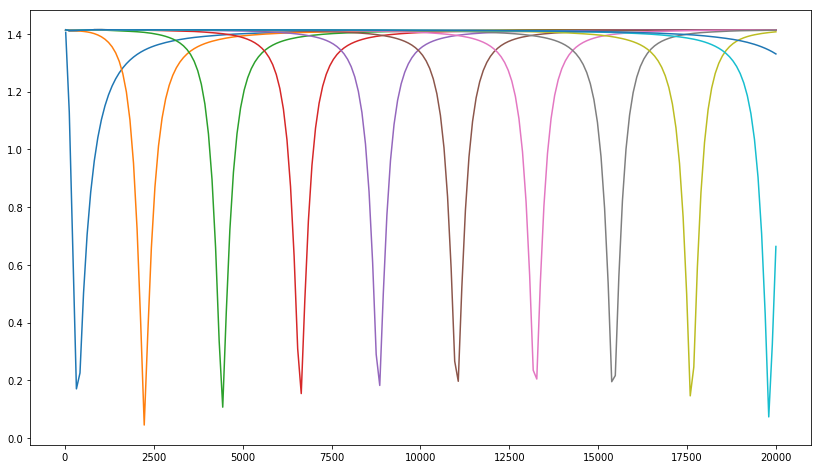

In [7]:
for th in np.linspace( 0,  np.pi, 11 ):
    print( "theta=%lf" % (th))
    d = scanForP( 0.95 * cos( th ), 0.95 * sin( th ) )
    plt.plot( d[ 0 ], d[ 1 ] )
    

And so from those two plots we can conclude the following

* the magnitude of the real part controls the width of the filter. 0.99 is tight, 0.7 is fat
* the angle (between 0 and pi basically - we can stay in that Q1/Q2 since the imaginary prt isn't in the eq) controls the filter position

In [8]:
# OK so lets make a multi-square-wave
freq = 220.0

def sqrBuf( freq ):
    n = (int)( sample_rate / 0.25 )
    t = np.linspace( 0, n-1, n ) / sample_rate
    return [ 1 if ( sin( te * 2 * np.pi * freq) > 0 ) else 0 for te in t]

s220 = sqrBuf( 220 )
s4 = sqrBuf( 440 * pow( 2.0, 3.0/12.0 ) )
s7 = sqrBuf( 220 * pow( 2.0, 7.0/12.0 ) )
chord = np.add( np.add( s220, s4 ), s7 )
p( chord )

In [9]:
class Phaser:
    def __init__(self):
        self.nfilters = 6
        self.filters = [ APF( 0, 0 ) for r in range(self.nfilters)  ]
        self.dtheta = np.pi / 2.0 / ( self.nfilters + 1 )
        self.theta0 = [ ( i + 0.5 ) * self.dtheta for i in range( self.nfilters )]
        self.r = 0.92
        self.lfofr = 1
        self.t = 0
        self.dt = 1.0 / sample_rate
        
    def process(self,inp):
        lfo = 0.47 * sin( self.t * self.lfofr * 2 * np.pi )
        self.t = self.t + self.dt
        [a.setPolar( self.r + 0.03 * lfo, th0 + self.dtheta * lfo) for (a,th0) in zip( self.filters, self.theta0)]
        filt = inp
        for a in self.filters:
            filt = a.process( filt )
        
        return 0.5 * inp + 0.5 * filt

In [10]:
ph = Phaser()
res = [ ph.process( x ) for x in chord ]

In [11]:
p( res )

In [12]:
p( chord )